# Data Preprocessing

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np

DATABASE_PATH = '../../database.db'
TEXT_COLUMN = 'descripcion_filtrado'
CLASS_COLUMN = 'categoria'
SQL_SENTENCE = 'SELECT %s, %s FROM licitaciones' % (TEXT_COLUMN, CLASS_COLUMN)
LANGUAGE = 'spanish'
RANDOM_SEED = 971122

conn = sqlite3.connect(DATABASE_PATH)
df = pd.read_sql(SQL_SENTENCE, conn)

print('The dataset has a total of %d samples' % len(df))
print('The dataset has a total of %d classes' % len(np.unique(df[CLASS_COLUMN])))

The dataset has a total of 26989 samples
The dataset has a total of 7 classes


In [2]:
from sklearn.model_selection import train_test_split

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(
    df[TEXT_COLUMN], df[CLASS_COLUMN], test_size=0.2, random_state=RANDOM_SEED)

x_validation, x_test, y_validation, y_test = train_test_split(
    x_validation_and_test, y_validation_and_test, test_size=0.5, random_state=RANDOM_SEED)

print("Train set has a total of %d samples" % len(x_train))
print('Validation set and test set have a each one a total of of %d samples' % len(x_validation))

Train set has a total of 21591 samples
Validation set and test set have a each one a total of of 2699 samples


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def evaluate(train_x, train_y, test_x, test_y, vectorizer):
    classifier = LogisticRegression(n_jobs=-1, solver='lbfgs', multi_class='multinomial', random_state=RANDOM_SEED)
    
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])
    
    pipeline_classifier = pipeline.fit(train_x, train_y)
    y_predicted = pipeline_classifier.score(test_x, test_y)
    return y_predicted
    
def observe_classification(train_x, train_y, test_x, test_y, vectorizer_params, title, use_count_vectorizer=True):
    predictions = []
    
    for num_features in range(2000, 20001, 1000):
        vectorizer = None
        if use_count_vectorizer:
            vectorizer = CountVectorizer(max_features=num_features)
        else:
            vectorizer = TfidfVectorizer(max_features=num_features)
        vectorizer.set_params(**vectorizer_params)
        prediction = evaluate(train_x, train_y, test_x, test_y, vectorizer)
        result = {
            'num_features': num_features,
            'score': prediction,
            'title': title
        }
        print('Training with %d features (%s): %.8f' % (num_features, title, prediction), end='\r')
        predictions.append(result)
    return predictions

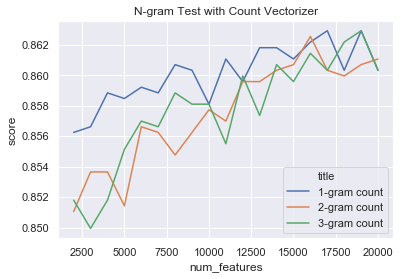

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions_dfs = []
for i in range(1, 4):
    params_vectorizer = {'ngram_range': (1, i)}
    predictions = observe_classification(x_train, y_train, x_test, y_test, params_vectorizer, '%d-gram count' % i)
    predictions_dfs.append(pd.DataFrame(predictions))
    
predictions_super_df_count = pd.concat(predictions_dfs, ignore_index=True)

sns.set()
plt.title('N-gram Test with Count Vectorizer')
sns.lineplot(x='num_features', y='score', hue='title', data=predictions_super_df_count)

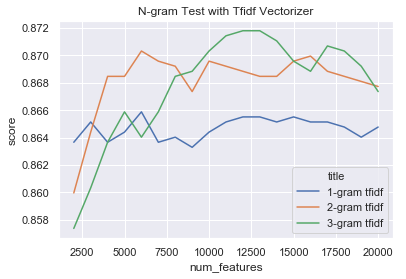

In [5]:
predictions_dfs = []
for i in range(1, 4):
    params_vectorizer = {'ngram_range': (1, i)}
    predictions = observe_classification(x_train, y_train, x_test, y_test, params_vectorizer, '%d-gram tfidf' % i, False)
    predictions_dfs.append(pd.DataFrame(predictions))
    
predictions_super_df_tfidf = pd.concat(predictions_dfs, ignore_index=True)

plt.title('N-gram Test with Tfidf Vectorizer')
sns.lineplot(x='num_features', y='score', hue='title', data=predictions_super_df_tfidf)

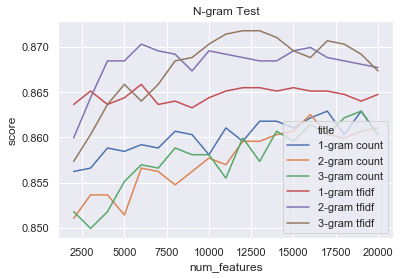

In [6]:
predictions_hyper_df = pd.concat([predictions_super_df_count, predictions_super_df_tfidf])
plt.title('N-gram Test')
sns.lineplot(x='num_features', y='score', hue='title', data=predictions_hyper_df)

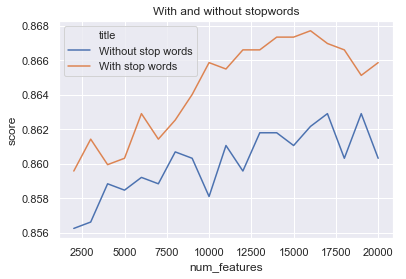

In [9]:
from nltk.corpus import stopwords

predictions_dfs = []
options_stop_words = [(None, 'Without stop words'),
                      (set(stopwords.words(LANGUAGE)), 'With stop words')]

for option, name in options_stop_words:
    params_vectorizer = {'stop_words': option}
    predictions = observe_classification(x_train, y_train, x_test, y_test, params_vectorizer, '%s' % name)
    predictions_dfs.append(pd.DataFrame(predictions))
    
predictions_super_df = pd.concat(predictions_dfs, ignore_index=True)
plt.title('With and without stopwords')
sns.lineplot(x='num_features', y='score', hue='title', data=predictions_super_df)